# TODO

* Move file to root dir
* Change all paths `../data` to `./data`

# Day 2: SageMaker Inference

In [1]:
%cd /root/sagemaker-workshop-420/

BUCKET = 'sagemaker-workshop-420'
PREFIX = 'data'

LOCAL_DATA_DIRECTORY = './data/'

/root/sagemaker-workshop-420


## 1. Loading a pretrained model

In [2]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn import SKLearnModel

In [3]:
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
print(role)

arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200402T065938


### TODO Mention how misleading the documentation can be

In [43]:
model_data = 's3://sagemaker-us-east-2-209970524256/sagemaker-scikit-learn-2020-04-03-11-03-52-730/output/model.tar.gz'
entry_point = '../day_1/sklearn_iris.py'

sklearn_model = SKLearnModel(model_data=model_data,
                             role=role, 
                             # I don't know why we need to provide this path here
                             entry_point=entry_point)

In [18]:
sklearn_predictor = sklearn_model.deploy(initial_instance_count=1,
                                         instance_type="ml.m4.xlarge")

-------------!

In [21]:
iris_df = pd.read_csv("../data/iris.csv", header=None)
iris_df.head()

,0,1,2,3,4
0,0.0,5.1,3.5,1.4,0.2
1,0.0,4.9,3.0,1.4,0.2
2,0.0,4.7,3.2,1.3,0.2
3,0.0,4.6,3.1,1.5,0.2
4,0.0,5.0,3.6,1.4,0.2


In [22]:
iris_X = iris_df.iloc[:,1:]
iris_y = iris_df.iloc[:,0]

In [23]:
iris_preds = sklearn_predictor.predict(iris_X.values)

In [26]:
print(iris_preds)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


### Endpoint cleanup <a class="anchor" id="endpoint_cleanup"></a>

When you're done with the endpoint, you'll want to clean it up.

In [27]:
sklearn_predictor.delete_endpoint()

## Batch Transform <a class="anchor" id="batch_transform"></a>
We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [44]:
sklearn_transformer = sklearn_model.transformer(instance_count=1,
                                                instance_type='ml.m4.xlarge')

### Prepare Input Data <a class="anchor" id="prepare_input_data"></a>
We will use the training data file we uploaded yesterday for inference.

```
An example of input file content:
                Record1-Attribute1, Record1-Attribute2, Record1-Attribute3, ..., Record1-AttributeM
                Record2-Attribute1, Record2-Attribute2, Record2-Attribute3, ..., Record2-AttributeM
                Record3-Attribute1, Record3-Attribute2, Record3-Attribute3, ..., Record3-AttributeM
                ...
                RecordN-Attribute1, RecordN-Attribute2, RecordN-Attribute3, ..., RecordN-AttributeM
```         

In [50]:
batch_inference_path = '../data/iris_inference.csv'
iris_X.to_csv(batch_inference_path, header=False, index=False)

In [51]:
!head ../data/iris_inference.csv

5.1,3.5,1.4,0.2
4.9,3.0,1.4,0.2
4.7,3.2,1.3,0.2
4.6,3.1,1.5,0.2
5.0,3.6,1.4,0.2
5.4,3.9,1.7,0.4
4.6,3.4,1.4,0.3
5.0,3.4,1.5,0.2
4.4,2.9,1.4,0.2
4.9,3.1,1.5,0.1


In [52]:
iris_X.to_csv(batch_inference_path, header=False, index=False)

train_input = sagemaker_session.upload_data(
    batch_inference_path,
    bucket=BUCKET,
    key_prefix="{}/sklearn".format(PREFIX))

train_input

's3://sagemaker-workshop-420/data/sklearn/iris_inference.csv'

### Run Transform Job <a class="anchor" id="run_transform_job"></a>
Using the Transformer, run a transform job on the S3 input data.

In [53]:
# Start a transform job and wait for it to finish
sklearn_transformer.transform(train_input, content_type='text/csv')
print('Waiting for transform job: ' + sklearn_transformer.latest_transform_job.job_name)
sklearn_transformer.wait()

Waiting for transform job: sagemaker-scikit-learn-2020-04-09-10-17-2020-04-09-10-26-31-077
.....................
Processing /opt/ml/code
  Created wheel for sklearn-iris: filename=sklearn_iris-1.0.0-py2.py3-none-any.whl size=7004 sha256=eab9d5d8bdbb951d487b33d15d6db8f920d1c3e2fbce1a5c29f58ce6f1ae6df3
  Stored in directory: /tmp/pip-ephem-wheel-cache-z51dsq5d/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built sklearn-iris
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2020-04-09 10:29:39 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2020-04-09 10:29:39 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2020-04-09 10:29:39 +0000] [37] [INFO] Using worker: gevent
[2020-04-09 10:29:39 +0000] [40] [INFO] Booting worker with pid: 40
[2020-04-09 10:29:4

### Check Output Data  <a class="anchor" id="check_output_data"></a>
After the transform job has completed, download the output data from S3. For each file **FILENAME** in the input data, we have a corresponding file **FILENAME.out** containing the predicted labels from each input row. We can compare the predicted labels to the true labels saved earlier.

In [55]:
batch_output = sklearn_transformer.output_path
batch_output

's3://sagemaker-us-east-2-209970524256/sagemaker-scikit-learn-2020-04-09-10-17-2020-04-09-10-26-31-077'

In [62]:
# Download the output data from S3 to local filesystem
boto_session.client('s3').download_file(
    Bucket='sagemaker-us-east-2-209970524256',
    Key='sagemaker-scikit-learn-2020-04-09-10-17-2020-04-09-10-26-31-077/iris_inference.csv.out',
    Filename='../data/iris_inference.csv.out')

In [63]:
!head ../data/iris_inference.csv.out

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

## 3. Model Monitor

In [19]:
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()
role = get_execution_role()

---
## Data

Mobile operators have historical records that tell them which customers ended up churning and which continued using the service. We can use this historical information to train an ML model that can predict customer churn. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model to have the model predict whether this customer will churn. 

The dataset we use is publicly available and was mentioned in [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. The `data` folder that came with this notebook contains the dataset, which we've already preprocessed for this walkthrough. The dataset has been split into training and validation sets. To see how the dataset was preprocessed, see this notebook: [XGBoost customer churn notebook that starts with the original dataset](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb). 

We'll train on a .csv file without the header. But for now, the following cell uses `pandas` to load some of the data from a version of the training data that has a header. 

Explore the data to see the dataset's features and the data that will be used to train the model.

In [5]:
# Set the path we can find the data files that go with this notebook
local_data_path = './data/xgb-churn/training-dataset-with-header.csv'
data = pd.read_csv(local_data_path)
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page
data

,Churn,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0,106,0,274.4,120,198.6,82,160.8,62,6.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
1,0,28,0,187.8,94,248.6,86,208.8,124,10.6,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
2,1,148,0,279.3,104,201.6,87,280.8,99,7.9,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0
3,0,132,0,191.9,107,206.9,127,272.0,88,12.6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
4,0,92,29,155.4,110,188.5,104,254.9,118,8.0,4,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0,106,0,194.8,133,213.4,73,190.8,92,11.5,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0
2329,1,125,0,143.2,80,88.1,94,233.2,135,8.8,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2330,0,129,0,143.7,114,297.8,98,212.6,86,11.4,8,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2331,0,159,0,198.8,107,195.5,91,213.3,120,16.5,7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


Now we'll upload the files to S3 for training. Since we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [13]:
s3_input_train = sagemaker_session.upload_data(
    './data/xgb-churn/train.csv',
    bucket=BUCKET,
    key_prefix='xgb-churn')

s3_input_validation = sagemaker_session.upload_data(
    './data/xgb-churn/validation.csv',
    bucket=BUCKET,
    key_prefix='xgb-churn')

s3_input_train = sagemaker.s3_input(s3_data=s3_input_train, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=s3_input_validation, content_type='csv')

---
## Train

We'll use the XGBoost library to train a class of models known as gradient boosted decision trees on the data that we just uploaded. 

Because we're using XGBoost, we first need to specify the locations of the XGBoost algorithm containers.

In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri
xgboost_image_name = get_image_uri(boto_session.region_name, 'xgboost', repo_version='0.90-2')
xgboost_image_name

'257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [43]:
xgboost_prefix = 'xgb-churn'

In [23]:
hyperparams = {"max_depth":5,
               "subsample":0.8,
               "num_round":600,
               "eta":0.2,
               "gamma":4,
               "min_child_weight":6,
               "silent":0,
               "objective":'binary:logistic'}

xgb = sagemaker.estimator.Estimator(image_name=xgboost_image_name,
                                    role=role,
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(BUCKET, xgboost_prefix),
                                    base_job_name="xgboost-customer-churn",
                                    sagemaker_session=sagemaker_session)

xgb.fit({'train': s3_input_train,
         'validation': s3_input_validation})

2020-04-10 10:58:37 Starting - Starting the training job...
2020-04-10 10:58:38 Starting - Launching requested ML instances...
2020-04-10 10:59:35 Starting - Preparing the instances for training......
2020-04-10 11:00:25 Downloading - Downloading input data...
2020-04-10 11:00:46 Training - Downloading the training image..
2020-04-10 11:01:31 Uploading - Uploading generated training model
2020-04-10 11:01:31 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[11:01:16] 2333x69 matrix with 160

---
## Host the model

Now that we've trained the model, let's deploy it to a hosted endpoint. To monitor the model after it's hosted and serving requests, we'll also add configurations to capture data that is being sent to the endpoint.

In [35]:
import time
from time import strftime, gmtime
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.predictor import csv_serializer

In [26]:
data_capture_prefix = '{}/datacapture'.format(xgboost_prefix)

endpoint_name = "xgboost-customer-churn-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName = {}".format(endpoint_name))

EndpointName = xgboost-customer-churn-2020-04-10-11-04-02


In [29]:
data_capture_config = DataCaptureConfig(enable_capture=True,
                                        sampling_percentage=100,
                                        destination_s3_uri='s3://{}/{}'.format(BUCKET, data_capture_prefix))

In [30]:
xgb_predictor = xgb.deploy(initial_instance_count=1, 
                           instance_type='ml.m4.xlarge',
                           endpoint_name=endpoint_name,
                           data_capture_config=data_capture_config)

-------------!

### Invoke the deployed model

Now that we have a hosted endpoint running, we can make real-time predictions from our model by making an http POST request.  But first, we need to set up serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [33]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll loop over our test dataset and collect predictions by invoking the XGBoost endpoint:

In [36]:
print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(endpoint_name))

with open('data/xgb-churn/test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        #print(payload)
        #break
        response = xgb_predictor.predict(data=payload)
        time.sleep(0.5)

Sending test traffic to the endpoint xgboost-customer-churn-2020-04-10-11-04-02. 
Please wait for a minute...


### Verify that data is captured in Amazon S3

When we made some real-time predictions by sending data to our endpoint, we should have also captured that data for monitoring purposes. 

Let's list the data capture files stored in Amazon S3. Expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [41]:
import json
from sagemaker.s3 import S3Uploader, S3Downloader

In [39]:
current_endpoint_capture_prefix = '{}/{}'.format(data_capture_prefix, endpoint_name)
print("Found Data Capture Files:")
capture_files = S3Downloader.list("s3://{}/{}".format(BUCKET, current_endpoint_capture_prefix))
print(capture_files)

Found Data Capture Files:
['s3://sagemaker-workshop-420/xgb-churn/datacapture/xgboost-customer-churn-2020-04-10-11-04-02/AllTraffic/2020/04/10/11/13-04-100-72cc8c73-e072-4ddb-aa98-8b73c4003a34.jsonl']


All the data captured is stored in a SageMaker specific json-line formatted file. Next, Let's take a quick peek at the contents of a single line in a pretty formatted json so that we can observe the format a little better.

In [42]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:2000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.014719205908477306",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "5b8d2be2-441b-4264-8e59-5d23a1e52b36",
    "inferenceTime": "2020-04-10T11:13:04Z"
  },
  "eventVersion": "0"
}


---
## Amazon SageMaker Model Monitor

Amazon SageMaker Model Monitor lets you monitor and evaluate the data observed by endpoints. It works like this:
1. We need to create a baseline that we can use to compare real-time traffic against. 
1. When a baseline is ready, we can set up a schedule to continously evaluate and compare against the baseline.
1. We can send synthetic traffic to trigger alarms.

**Important**: It takes an hour or more to complete this section because the shortest monitoring polling time is one hour. The following graphic shows how the monitoring results look after running for a few hours and some of the errors triggered by synthetic traffic.

![model monitor example](./images/view_model_monitor_output.gif)

### Baselining and continous monitoring

#### 1. Constraint suggestion with the baseline (training) dataset

The training dataset that you use to train a model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema must match exactly (for example, they should have the same number and type of features).

Using our training dataset, let's ask Amazon SageMaker Model Monitor to suggest a set of baseline `constraints` and generate descriptive `statistics` so we can explore the data. For this example, let's upload the training dataset, which we used to train model. We'll use the dataset file with column headers so we have descriptive feature names.

In [44]:
baseline_prefix = xgboost_prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(BUCKET, baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(BUCKET, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))
baseline_data_path = S3Uploader.upload("./data/xgb-churn/training-dataset-with-header.csv", baseline_data_uri)

Baseline data uri: s3://sagemaker-workshop-420/xgb-churn/baselining/data
Baseline results uri: s3://sagemaker-workshop-420/xgb-churn/baselining/results


##### Create a baselining job with the training dataset

Now that we have the training data ready in S3, let's start a job to `suggest` constraints. To generate the constraints, the convenient helper starts a `ProcessingJob` using a ProcessingJob container provided by Amazon SageMaker.

In [45]:
my_default_monitor = DefaultModelMonitor(role=role,
                                         instance_count=1,
                                         instance_type='ml.m5.xlarge',
                                         volume_size_in_gb=20,
                                         max_runtime_in_seconds=3600)

baseline_job = my_default_monitor.suggest_baseline(baseline_dataset=baseline_data_path,
                                                   dataset_format=DatasetFormat.csv(header=True),
                                                   output_s3_uri=baseline_results_uri,
                                                   wait=True)


Job Name:  baseline-suggestion-job-2020-04-10-11-23-10-464
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-workshop-420/xgb-churn/baselining/data/training-dataset-with-header.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-workshop-420/xgb-churn/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..................2020-04-10 11:26:02,041 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/baseline-suggestion-job-2020-04-10-11-23-10-464', 'ProcessingJobName': 'baseline-suggestion-job-2020-04-10-11-23-10-464', 'Environment': {'dataset_format': '{"csv": {"header": true, "output_columns_position": "START"}}', 'dataset_source':

Once the job succeeds, we can explore the `baseline_results_uri` location in s3 to see what files where stored there.

In [46]:
print("Found Files:")
S3Downloader.list("s3://{}/{}".format(BUCKET, baseline_results_prefix))

Found Files:


['s3://sagemaker-workshop-420/xgb-churn/baselining/results/constraints.json',
 's3://sagemaker-workshop-420/xgb-churn/baselining/results/statistics.json']

We have a`constraints.json` file that has information about suggested constraints. We also have a `statistics.json` which contains statistical information about the data in the baseline.

In [47]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'co...",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70...."
2,VMail Message,Integral,2333,0,8.214316,19164.0,13.776908,0.0,51.0,"[{'lower_bound': 0.0, 'upper_bound': 5.1, 'cou...",0.64,2048.0,"[[19.0, 0.0, 0.0, 40.0, 36.0, 0.0, 0.0, 24.0, ..."
3,Day Mins,Fractional,2333,0,180.226489,420468.4,53.987179,0.0,350.8,"[{'lower_bound': 0.0, 'upper_bound': 35.08, 'c...",0.64,2048.0,"[[178.1, 160.3, 197.1, 105.2, 283.1, 113.6, 23..."
4,Day Calls,Integral,2333,0,100.259323,233905.0,20.165008,0.0,165.0,"[{'lower_bound': 0.0, 'upper_bound': 16.5, 'co...",0.64,2048.0,"[[110.0, 138.0, 117.0, 61.0, 112.0, 87.0, 122...."
5,Eve Mins,Fractional,2333,0,200.050107,466716.9,50.015928,31.2,361.8,"[{'lower_bound': 31.2, 'upper_bound': 64.26, '...",0.64,2048.0,"[[212.8, 221.3, 227.8, 341.3, 286.2, 158.6, 29..."
6,Eve Calls,Integral,2333,0,99.573939,232306.0,19.675578,12.0,170.0,"[{'lower_bound': 12.0, 'upper_bound': 27.8, 'c...",0.64,2048.0,"[[100.0, 92.0, 128.0, 79.0, 86.0, 98.0, 112.0,..."
7,Night Mins,Fractional,2333,0,201.388598,469839.6,50.627961,23.2,395.0,"[{'lower_bound': 23.2, 'upper_bound': 60.37999...",0.64,2048.0,"[[226.3, 150.4, 214.0, 165.7, 261.7, 187.7, 20..."
8,Night Calls,Integral,2333,0,100.227175,233830.0,19.282029,42.0,175.0,"[{'lower_bound': 42.0, 'upper_bound': 55.3, 'c...",0.64,2048.0,"[[123.0, 120.0, 101.0, 97.0, 129.0, 87.0, 112...."
9,Intl Mins,Fractional,2333,0,10.253065,23920.4,2.778766,0.0,18.4,"[{'lower_bound': 0.0, 'upper_bound': 1.8399999...",0.64,2048.0,"[[10.0, 11.2, 9.3, 6.3, 11.3, 10.5, 0.0, 9.7, ..."


In [48]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True
5,Eve Mins,Fractional,1.0,True
6,Eve Calls,Integral,1.0,True
7,Night Mins,Fractional,1.0,True
8,Night Calls,Integral,1.0,True
9,Intl Mins,Fractional,1.0,True


#### 2. Analyzing subsequent captures for data quality issues

Now that we've generated a baseline dataset and processed it to get baseline statistics and constraints, let's monitor and analyze the data being sent to the endpoint with monitoring schedules.

##### Create a schedule
First, let's create a monitoring schedule for the endpoint. The schedule specifies the cadence at which we want to run a new processing job so that we can compare recent data captures to the baseline.

In [49]:
# First, copy over some test scripts to the S3 bucket so that they can be used for pre and post processing
#code_prefix = '{}/code'.format(prefix)
#pre_processor_script = S3Uploader.upload('preprocessor.py', 's3://{}/{}'.format(bucket,code_prefix))
#s3_code_postprocessor_uri = S3Uploader.upload('postprocessor.py', 's3://{}/{}'.format(bucket,code_prefix))

We are ready to create a model monitoring schedule for the Endpoint created before and also the baseline resources (constraints and statistics) which were generated above.

In [55]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

reports_prefix = '{}/reports'.format(xgboost_prefix)
s3_report_path = 's3://{}/{}'.format(BUCKET, reports_prefix)

mon_schedule_name = 'xgboost-customer-churn-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(monitor_schedule_name=mon_schedule_name,
                                              endpoint_input=xgb_predictor.endpoint,
                                              #record_preprocessor_script=pre_processor_script,
                                              #post_analytics_processor_script=s3_code_postprocessor_uri,
                                              output_s3_uri=s3_report_path,
                                              statistics=my_default_monitor.baseline_statistics(),
                                              constraints=my_default_monitor.suggested_constraints(),
                                              schedule_cron_expression=CronExpressionGenerator.hourly(),
                                              enable_cloudwatch_metrics=True,
                                             )


Creating Monitoring Schedule with name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53


#### 3. Start generating some artificial traffic
The following block starts a thread to send some traffic to the endpoint. This allows us to continue to send traffic to the endpoint so that we'll have data continually captured for analysis. If there is no traffic, the monitoring jobs will start to fail later.

To terminate this thread, you need to stop the kernel.

In [56]:
from threading import Thread
from time import sleep
import time

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                                      ContentType='text/csv', 
                                                      Body=payload)
            time.sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, 'data/xgb-churn/test-dataset-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

##### List executions
Once the schedule is set up, jobs start at the specified intervals. The following code lists the last five executions. If you run this code soon after creating the hourly schedule, you might not see any executions listed. To see executions, you might have to wait until you cross the hour boundary (in UTC). The code includes the logic for waiting.

In [60]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()  

No executions found for schedule. monitoring_schedule_name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53
We created a hourly schedule above and it will kick off executions ON the hour.
We will have to wait till we hit the hour...
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgboost-customer-churn-model-schedule-2020-04-11-10-36-53
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgboost-cu

##### Evaluate the latest execution and list the generated reports

In [63]:
latest_execution = mon_executions[-1]
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))
report_uri = latest_execution.output.destination

print("Found Report Files:")
S3Downloader.list(report_uri)

Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.
Found Report Files:


['s3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-10-11-04-02/xgboost-customer-churn-model-schedule-2020-04-11-10-36-53/2020/04/11/11/constraint_violations.json',
 's3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-10-11-04-02/xgboost-customer-churn-model-schedule-2020-04-11-10-36-53/2020/04/11/11/constraints.json',
 's3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-10-11-04-02/xgboost-customer-churn-model-schedule-2020-04-11-10-36-53/2020/04/11/11/statistics.json']

##### List violations

If there are any violations compared to the baseline, they will be generated here. Let's list the violations.

In [64]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

,feature_name,constraint_check_type,description
0,State_UT,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
1,State_AR,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
2,Int'l Plan_yes,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
3,State_WY,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
4,State_IL,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
5,State_KS,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
6,State_WV,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
7,State_ME,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
8,State_NE,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."
9,State_VA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.68676585747846% of data is Integral."


## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [67]:
processing_job_arn = latest_execution.describe()['ProcessingJobArn']
processing_job_arn

'arn:aws:sagemaker:us-east-2:209970524256:processing-job/model-monitoring-202004111100-a71a88f315417d8d74d5f73f'

In [72]:
import os

from sagemaker.model_monitor import MonitoringExecution

In [70]:
execution = MonitoringExecution.from_processing_arn(sagemaker_session=sagemaker_session, processing_job_arn=processing_job_arn)
exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [73]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

## Overview

The code below shows the violations and constraichecks across all features in a simple table.

In [74]:
import utils as mu

In [75]:
mu.show_violation_df(baseline_statistics=baseline_statistics, latest_statistics=execution_statistics, violations=violations)

,data_type,completeness,baseline_drift,categorical_values
Account Length,Integral,100.00%,N/A,N/A
Area Code_408,Fractional,100.00%,N/A,N/A
Area Code_415,Fractional,100.00%,N/A,N/A
Area Code_510,Fractional,100.00%,N/A,N/A
Churn,Fractional,100.00%,N/A,N/A
CustServ Calls,Integral,100.00%,N/A,N/A
Day Calls,Integral,100.00%,N/A,N/A
Day Mins,Fractional,100.00%,N/A,N/A
Eve Calls,Integral,100.00%,N/A,N/A
Eve Mins,Fractional,100.00%,N/A,N/A


## Distributions

This section visualizes the distribution and renders the distribution statistics for all features

In [76]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,1277,0,0.138090,176.340785,0.266752,0.002702,0.993593
Account Length,1277,0,100.061864,127779.000000,39.677736,10.000000,232.000000
VMail Message,1277,0,8.024589,10247.400000,13.438507,0.000000,44.000000
Day Mins,1277,0,177.549178,226730.300000,55.229651,29.900000,328.100000
Day Calls,1277,0,101.383712,129467.000000,19.251376,36.000000,158.000000
...,...,...,...,...,...,...,...
Area Code_510,1277,0,0.261394,333.800000,0.440249,0.000000,1.200000
Int'l Plan_no,1277,0,0.922631,1178.200000,0.269452,0.000000,1.300000
Int'l Plan_yes,1277,0,0.080000,102.160000,0.269855,0.000000,1.000000
VMail Plan_no,1277,0,0.716993,915.600000,0.452403,0.000000,1.400000


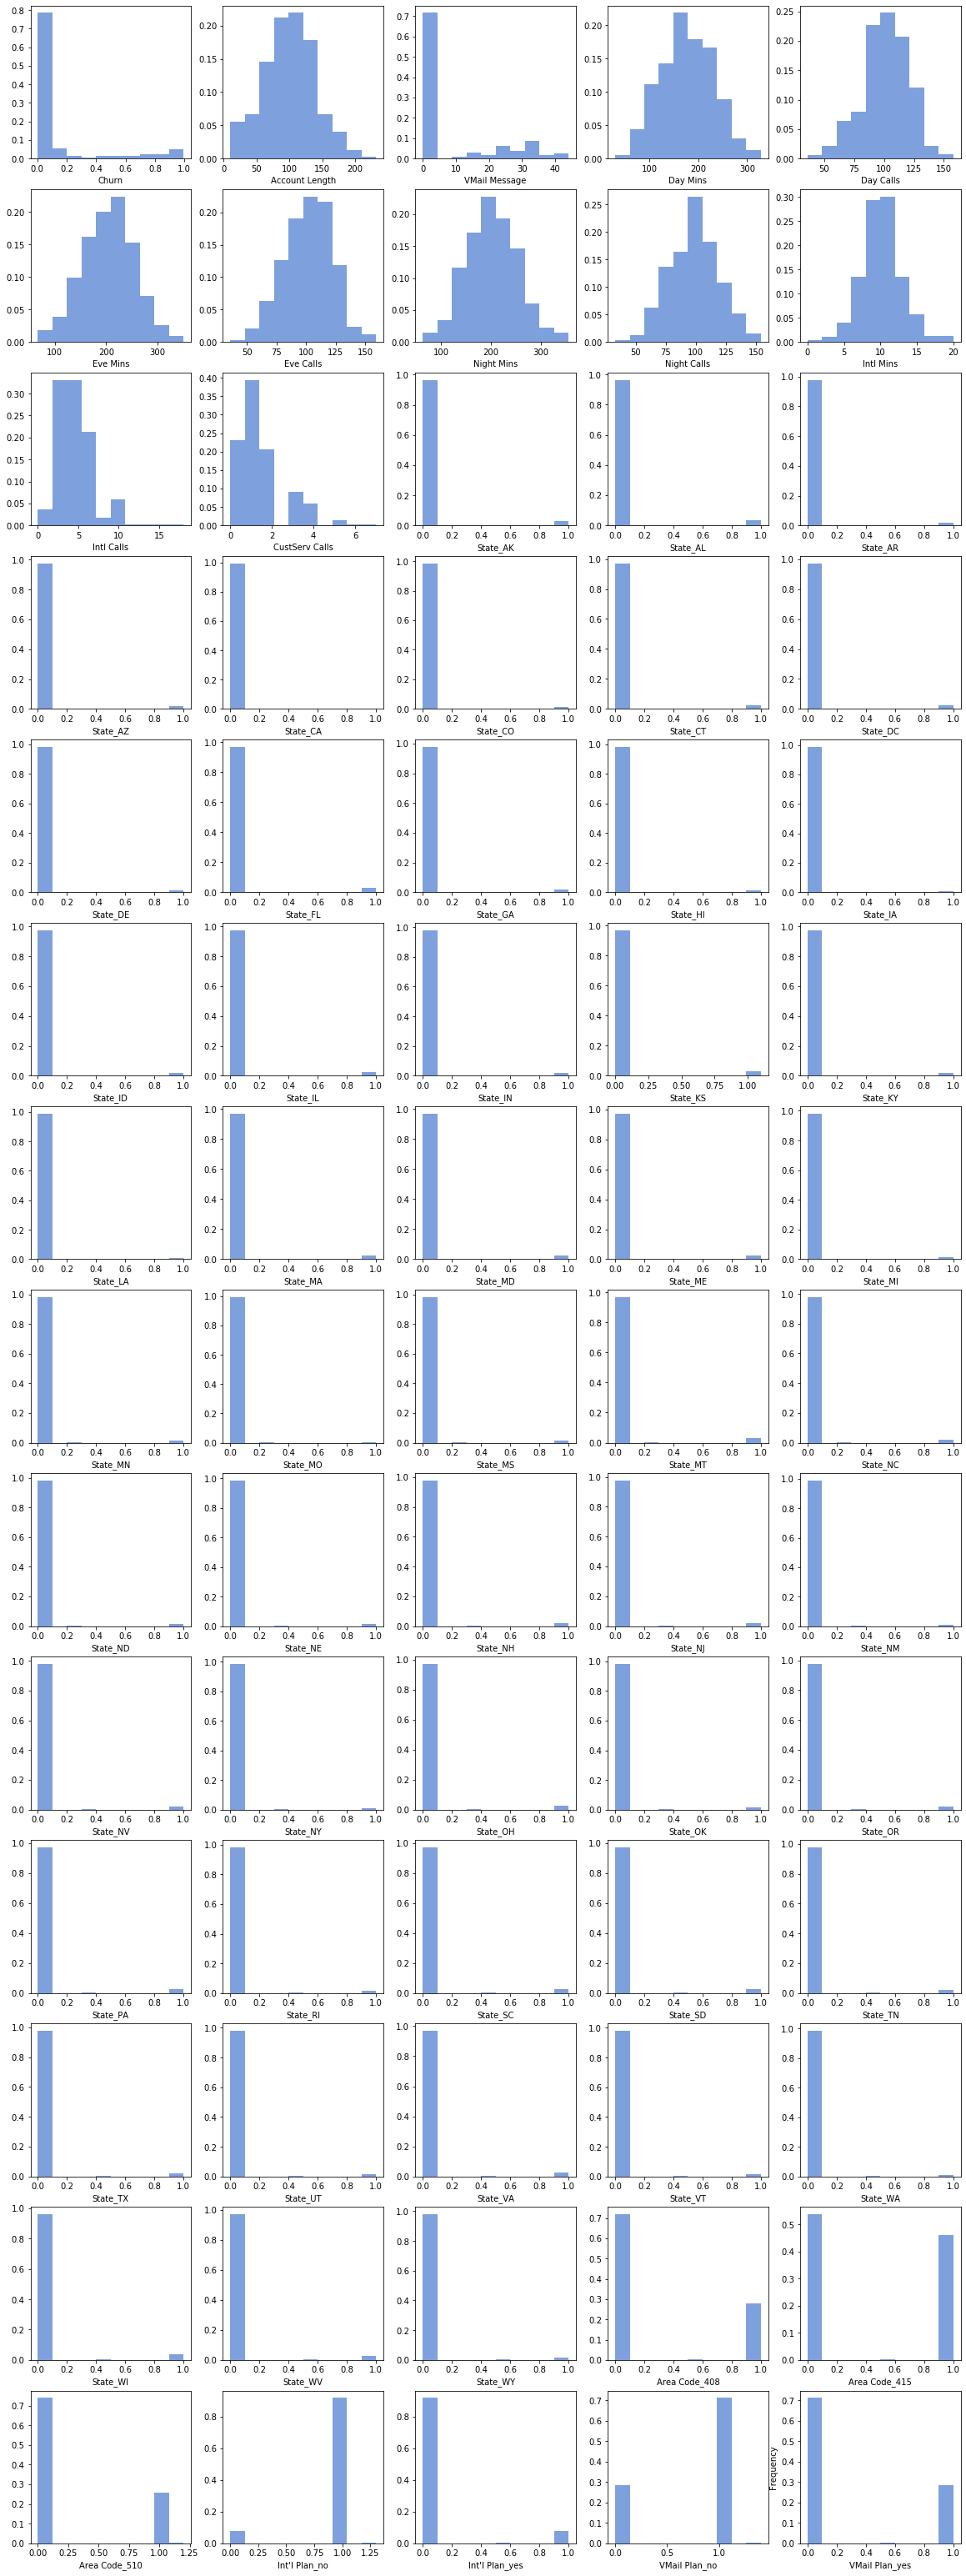

In [77]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,1277,0,0.138090,176.340785,0.266752,0.002702,0.993593
Account Length,1277,0,100.061864,127779.000000,39.677736,10.000000,232.000000
VMail Message,1277,0,8.024589,10247.400000,13.438507,0.000000,44.000000
Day Mins,1277,0,177.549178,226730.300000,55.229651,29.900000,328.100000
Day Calls,1277,0,101.383712,129467.000000,19.251376,36.000000,158.000000
...,...,...,...,...,...,...,...
Area Code_510,1277,0,0.261394,333.800000,0.440249,0.000000,1.200000
Int'l Plan_no,1277,0,0.922631,1178.200000,0.269452,0.000000,1.300000
Int'l Plan_yes,1277,0,0.080000,102.160000,0.269855,0.000000,1.000000
VMail Plan_no,1277,0,0.716993,915.600000,0.452403,0.000000,1.400000


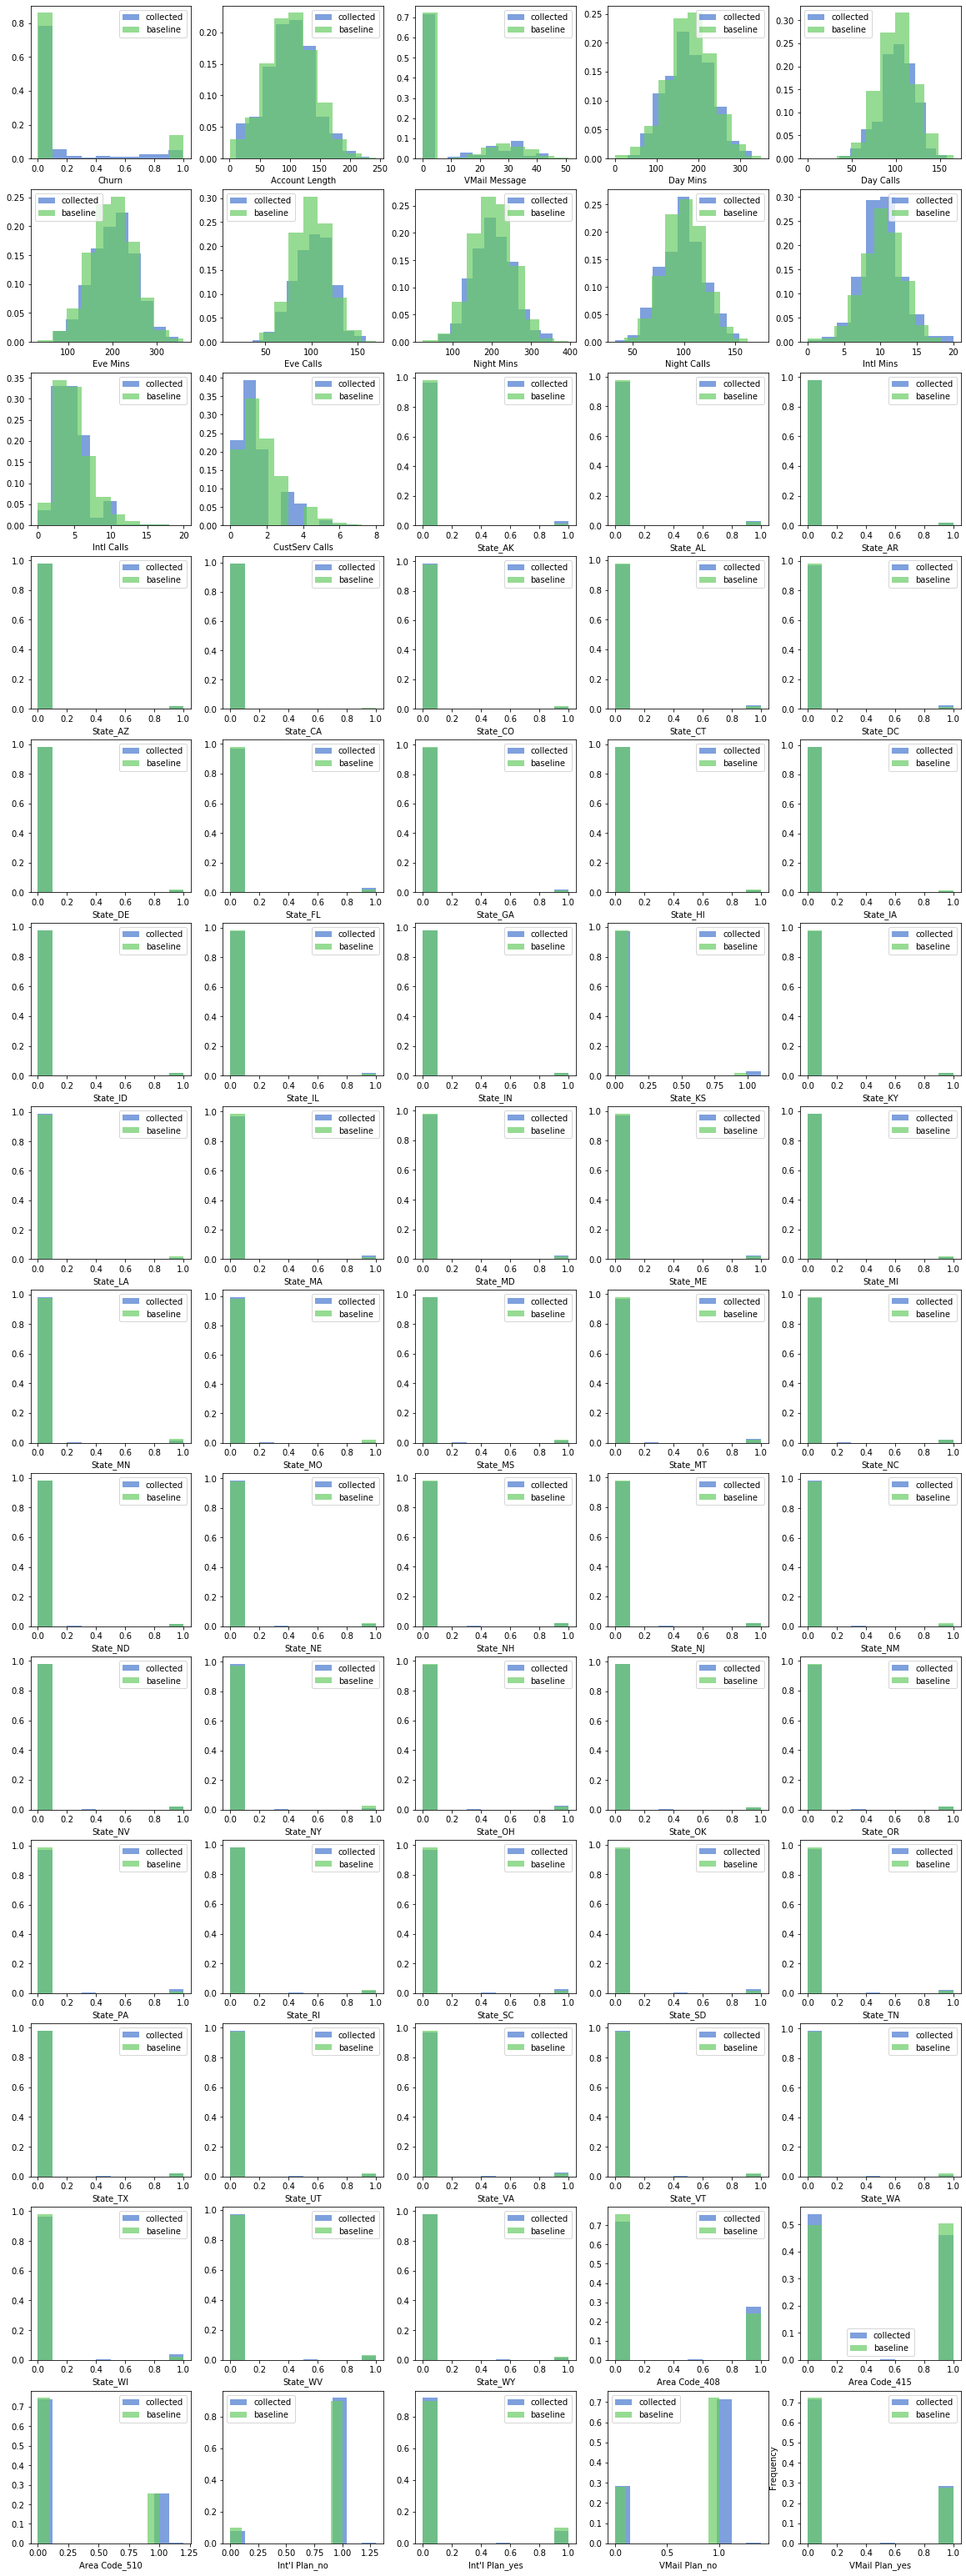

In [78]:
mu.show_distributions(features, feature_baselines)

## Clean up

If you no longer need this notebook, clean up your environment by running the following cell. It removes the hosted endpoint that you created for this walkthrough and prevents you from incurring charges for running an instance that you no longer need. It also cleans up all artifacts related to the experiments. 

You might also want to delete artifacts stored in the S3 bucket used in this notebook. To do so, open the Amazon S3 console, find the `sagemaker-studio-<region-name>-<account-name>` bucket, and delete the files associated with this notebook.

In [ ]:
#sess.delete_monitoring_schedule(mon_schedule_name)
sess.delete_endpoint(xgb_predictor.endpoint)
def cleanup(experiment):
    '''Clean up everything in the given experiment object'''
    for trial_summary in experiment.list_trials():
        trial = Trial.load(trial_name=trial_summary.trial_name)
        
        for trial_comp_summary in trial.list_trial_components():
            trial_step=TrialComponent.load(trial_component_name=trial_comp_summary.trial_component_name)
            print('Starting to delete TrialComponent..' + trial_step.trial_component_name)
            sm.disassociate_trial_component(TrialComponentName=trial_step.trial_component_name, TrialName=trial.trial_name)
            trial_step.delete()
            time.sleep(1)
         
        trial.delete()
    
    experiment.delete()

cleanup(customer_churn_experiment)